In [1]:
import os
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=1)  # 512x512 -> 256x256
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1)  # 256x256 -> 128x128

    def forward(self, x):
        x = F.relu(self.conv1(x))  # Downsample to 256x256
        x = F.relu(self.conv2(x))  # Downsample to 128x128
        return x  # Output shape: (batch_size, 32, 128, 128)

In [3]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        self.convt1 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1)  # 128x128 -> 256x256
        self.convt2 = nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=3, stride=2, padding=1, output_padding=1)  # 256x256 -> 512x512

        self.out_128 = nn.Conv2d(in_channels=32, out_channels=3, kernel_size=1)  # Output at 128x128
        self.out_256 = nn.Conv2d(in_channels=16, out_channels=3, kernel_size=1)  # Output at 256x256

    def forward(self, x):
        out_128 = torch.sigmoid(self.out_128(x))

        x = F.relu(self.convt1(x))
        out_256 = torch.sigmoid(self.out_256(x))

        x = F.relu(self.convt2(x))
        out_512 = torch.sigmoid(x)

        return out_128, out_256, out_512

In [4]:
class AutoEncoderMRL(nn.Module):
    def __init__(self):
        super(AutoEncoderMRL, self).__init__()
        self.encoder = Encoder()  # Downsampling: 512x512 -> 128x128
        self.decoder = Decoder()  # Upsampling: 128x128 -> 512x512

    def forward(self, x):
        emb = self.encoder(x)  # Get compressed representation
        out_128, out_256, out_512 = self.decoder(emb)  # Reconstruct at multiple resolutions
        return out_128, out_256, out_512, emb

In [5]:
def mrl_loss(outputs, targets, weights):
    """
    Compute the MRL loss as a weighted sum of reconstruction losses for different resolutions.

    :param outputs: Tuple containing reconstructed outputs at different resolutions (128x128, 256x256, 512x512).
    :param targets: Target images at the highest resolution (512x512).
    :param weights: List of weights for each resolution.
    :return: Combined loss value.
    """
    out_128, out_256, out_512 = outputs

    target_128 = F.interpolate(targets, size=(128, 128), mode='bilinear', align_corners=False)
    target_256 = F.interpolate(targets, size=(256, 256), mode='bilinear', align_corners=False)

    loss_128 = F.mse_loss(out_128, target_128)
    loss_256 = F.mse_loss(out_256, target_256)
    loss_512 = F.mse_loss(out_512, targets)

    # Weighted sum of losses
    total_loss = weights[0] * loss_128 + weights[1] * loss_256 + weights[2] * loss_512
    return total_loss/3

In [6]:
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# Custom Dataset for loading images from a single folder
class ImageDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]  # Filter image files
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
    
        img_path = os.path.join(self.folder_path, self.image_files[idx])

        image = Image.open(img_path)  
        if self.transform:
            image = self.transform(image)
        
        return image  


In [7]:
# Define transformations
transform = transforms.Compose([
    # transforms.Grayscale(num_output_channels=1),  # Ensure images are grayscale (if not already)
    transforms.Resize((512, 512)),  # Resize to 512x512
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])


folder_path = 'toys/train'

dataset = ImageDataset(folder_path, transform=transform)
batch_size = 16  
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


/home/hardik/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


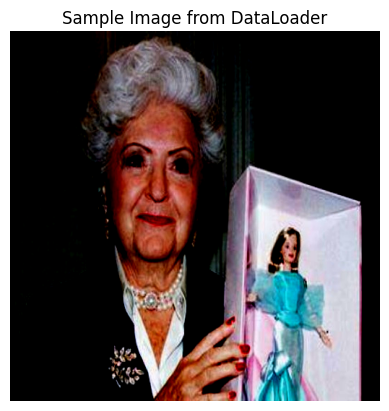

In [8]:
import matplotlib.pyplot as plt

images = next(iter(dataloader))

image = images[7].cpu().numpy().squeeze()
image = image.transpose(1, 2, 0)

plt.imshow(image, cmap='gray')
plt.title("Sample Image from DataLoader")
plt.axis('off')
plt.show()

In [9]:
target_128 = F.interpolate(images, size=(128, 128), mode='bilinear', align_corners=False)
target_256 = F.interpolate(images, size=(256, 256), mode='bilinear', align_corners=False)
target_128.shape

torch.Size([16, 3, 128, 128])

In [12]:
import torch
from torch import nn
from torch.optim import Adam

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

autoencoder_mrl = AutoEncoderMRL().to(device)

optimizer = Adam(autoencoder_mrl.parameters(), lr=1e-3)

mrl_weights = [1, 1, 1]  

# Training loop
num_epochs = 15
for epoch in range(num_epochs):
    autoencoder_mrl.train() 
    total_loss = 0

    for images in dataloader: 
        images = images.to(device)  

        out_128, out_256, out_512, _ = autoencoder_mrl(images)  # Outputs at 128x128, 256x256, 512x512

        loss = mrl_loss((out_128, out_256, out_512), images, mrl_weights)

        optimizer.zero_grad()  
        loss.backward()        
        optimizer.step()       
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


Epoch [1/15], Loss: 0.2873
Epoch [2/15], Loss: 0.2132
Epoch [3/15], Loss: 0.2060
Epoch [4/15], Loss: 0.2026
Epoch [5/15], Loss: 0.2046
Epoch [6/15], Loss: 0.2018
Epoch [7/15], Loss: 0.2034
Epoch [8/15], Loss: 0.2012
Epoch [9/15], Loss: 0.2007
Epoch [10/15], Loss: 0.2016
Epoch [11/15], Loss: 0.2008
Epoch [12/15], Loss: 0.2005
Epoch [13/15], Loss: 0.2006
Epoch [14/15], Loss: 0.1998
Epoch [15/15], Loss: 0.2002


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


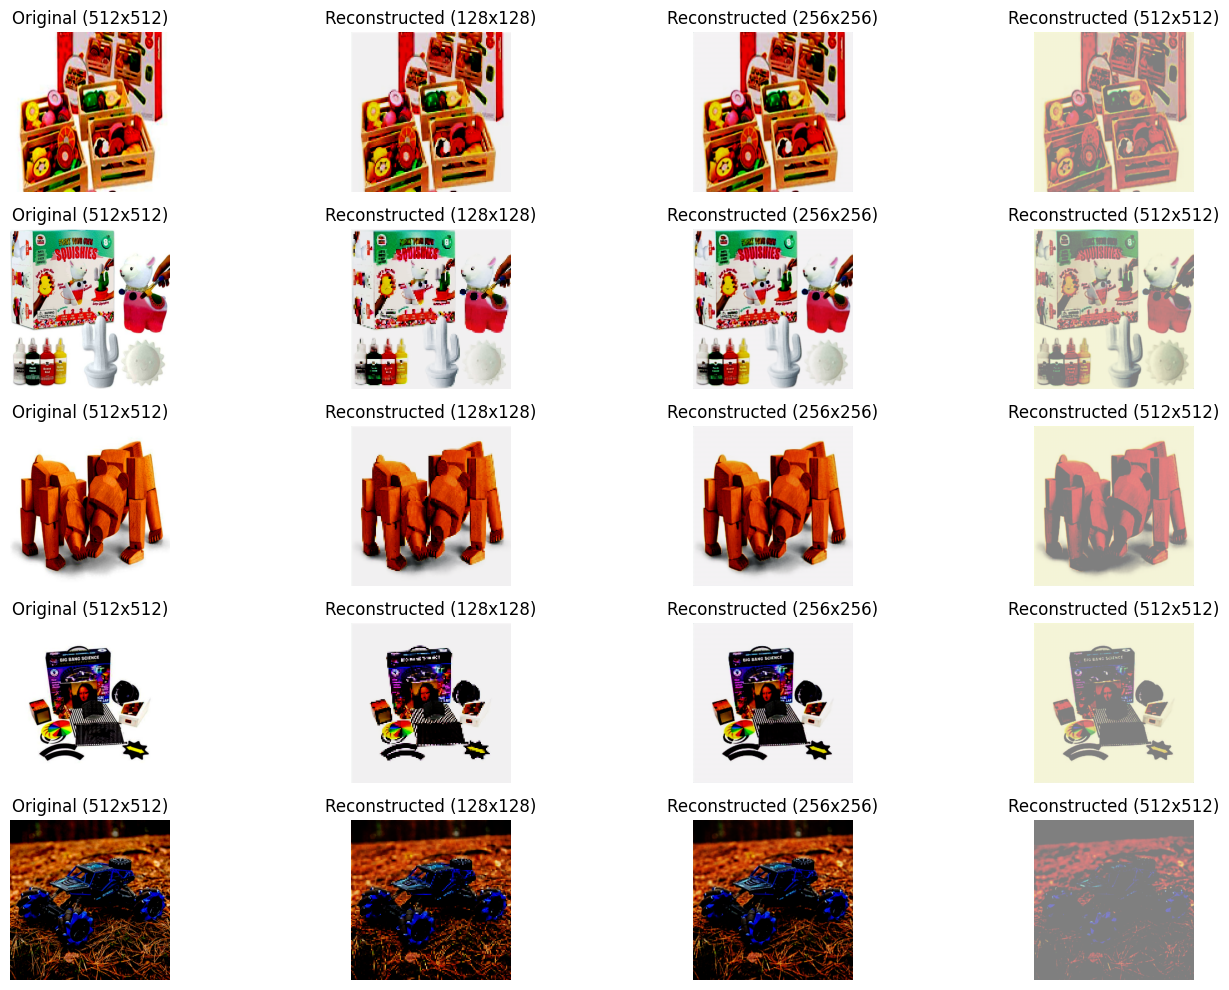

In [16]:
import matplotlib.pyplot as plt

# Set model to evaluation mode
autoencoder_mrl.eval()

images = next(iter(dataloader))
images = images.to(device)

with torch.no_grad():
    out_128, out_256, out_512, _ = autoencoder_mrl(images)

images = images.cpu().numpy()
out_128 = out_128.cpu().numpy()
out_256 = out_256.cpu().numpy()
out_512 = out_512.cpu().numpy()

# # Function to denormalize images (from [-1, 1] to [0, 1])
# def denormalize(tensor):
#     return (tensor * 0.5) + 0.5

# # Denormalize the images and outputs
# # images = denormalize(images)  # Original images
# out_128 = denormalize(out_128)  # Reconstructed 128x128
# out_256 = denormalize(out_256)  # Reconstructed 256x256
# out_512 = denormalize(out_512)  # Reconstructed 512x512

plt.figure(figsize=(15, 10))

for i in range(5):  # Visualize 5 images
    # Original image
    plt.subplot(5, 4, i * 4 + 1)
    plt.imshow(images[i].transpose(1, 2, 0)) 
    plt.title("Original (512x512)")
    plt.axis('off')

    # Reconstructed 128x128
    plt.subplot(5, 4, i * 4 + 2)
    plt.imshow(out_128[i].transpose(1, 2, 0)) 
    plt.title("Reconstructed (128x128)")
    plt.axis('off')

    # Reconstructed 256x256
    plt.subplot(5, 4, i * 4 + 3)
    plt.imshow(out_256[i].transpose(1, 2, 0)) 
    plt.title("Reconstructed (256x256)")
    plt.axis('off')

    # Reconstructed 512x512
    plt.subplot(5, 4, i * 4 + 4)
    plt.imshow(out_512[i].transpose(1, 2, 0)) 
    plt.title("Reconstructed (512x512)")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [14]:
images[1] - out_512[1]

array([[[ 1.81332052e-01,  7.71971941e-02,  6.22372031e-02, ...,
          3.72307301e-02,  8.59112740e-02,  1.16634071e-01],
        [ 9.49705839e-02,  3.83781195e-02,  3.20464969e-02, ...,
          4.34418917e-02,  3.24611664e-02,  1.03313088e-01],
        [ 8.88705254e-02,  1.65162086e-02,  2.61365175e-02, ...,
          2.11793184e-02,  2.95630097e-02,  5.72965741e-02],
        ...,
        [ 6.30024672e-02,  3.41372490e-02,  1.36516094e-02, ...,
          1.62400007e-02,  2.94277668e-02,  7.13938475e-02],
        [ 1.20565534e-01,  2.35561132e-02,  3.59963775e-02, ...,
          2.37679482e-02,  9.45975780e-02,  1.24307692e-01],
        [ 1.84709311e-01,  1.33232415e-01,  1.10069275e-01, ...,
          1.48952305e-01,  1.67099774e-01,  3.18093240e-01]],

       [[ 9.15794373e-02,  4.69503999e-02,  4.31430340e-02, ...,
          2.94153094e-02,  4.75362539e-02,  1.28259420e-01],
        [ 6.12739325e-02,  2.04556584e-02,  1.79048181e-02, ...,
         -4.59837914e-03,  1.86406374e

In [20]:
nn.MSELoss()(torch.tensor(images[3]), torch.tensor(out_512[3]))

tensor(0.8054)

In [26]:
autoencoder_mrl.eval()
total_loss = 0

folder_path = 'toys/test'
dataset_test = ImageDataset(folder_path, transform=transform)  
batch_size = 16
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

weights = [1.0, 1.0, 1.0]  

with torch.no_grad():
    for images in dataloader_test:  
        images = images.to(device)
        
        out_128, out_256, out_512, _ = autoencoder_mrl(images)
        
        target_128 = F.interpolate(images, size=(128, 128), mode='bilinear', align_corners=False)
        target_256 = F.interpolate(images, size=(256, 256), mode='bilinear', align_corners=False)
        
        loss_128 = nn.MSELoss()(out_128, target_128)
        loss_256 = nn.MSELoss()(out_256, target_256)
        loss_512 = nn.MSELoss()(out_512, images)
        
        loss = weights[0] * loss_128 + weights[1] * loss_256 + weights[2] * loss_512
        loss /= 3
        total_loss += loss.item()

average_loss = total_loss / len(dataloader_test)
print(f"Reconstruction Loss (MRL MSE): {average_loss:.4f}")


Reconstruction Loss (MRL MSE): 0.2332


In [ ]:
# Calculate reconstruction loss on the test dataset for AutoEncoderMRL
autoencoder_mrl.eval()
total_loss = 0

folder_path = 'toys/test'

dataset_test = ImageDataset(folder_path, transform=transform)  
batch_size = 16
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

mrl_weights = [1,1,1]

with torch.no_grad():  
    for images in dataloader_test:
        images = images.to(device)  

        out_128, out_256, out_512, _ = autoencoder_mrl(images)

        loss = mrl_loss((out_128, out_256, out_512), images, mrl_weights)
        total_loss += loss.item()  
average_loss = total_loss / len(dataloader_test)
print(f"Reconstruction Loss (MRL): {average_loss:.4f}")


Reconstruction Loss (MRL): 0.2356
